# Problem Description:

In this notebook, we apply the concepts of a Convolutional Neural Network to classify the images of the CIFAR-10 dataset, which is also available in the TensorFlow API. The dataset consists of 60.000 color images, divided in 10 classes. The classes are: airplane, automobile, bird, cat, deer,	dog, frog, horse, ship, and truck. The images are represented as a matrix of 32 x 32 x 3. 

Here, we apply the concepts of CNNs to classify those images, but we also move forward and try to improve the results by applying the concepts of <u>Batch Normalization</u> and also <u>Data Augmentation</u>. On previous tasks, we applied the strided convolution. Here, we apply the <u>Max Pooling</u>. At the end, we compare the strategies of applying both Batch Norm. and Data Augmentation and check which one produces better results.

The notebook is organized as follows:

1. Imports
2. Dataset
3. Build Model
4. Batch Normalization
5. Data Augmentation
6. Evaluation 

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

### Dataset

In [7]:
# Load in the data

cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print(f"Train shape: {x_train.shape}")

Train shape: (50000, 32, 32, 3)


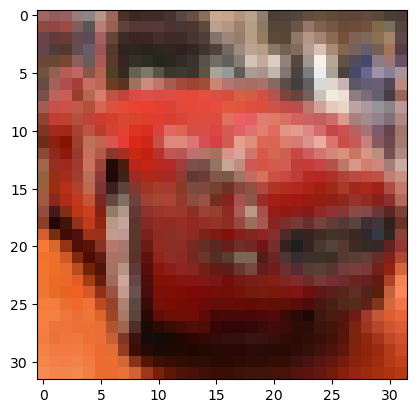

In [8]:
# Ploting the 5th image of the train set

plt.imshow(x_train[5]);

In [9]:
# Checking the number of classes

K = len(set(y_train))
print("Number of classes:", K)

Number of classes: 10


### Build the Model

In [10]:
# Build the model using the functional API

i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), strides = 2, activation = 'relu')(i)
x = Conv2D(64, (3, 3), strides = 2, activation = 'relu')(x)
x = Conv2D(128, (3, 3), strides = 2, activation = 'relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x)

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15


I0000 00:00:1720392083.994988   13498 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 14s 7ms/step - loss: 1.5709 - accuracy: 0.4269 - val_loss: 1.3038 - val_accuracy: 0.5270
Epoch 2/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2887 - accuracy: 0.5368 - val_loss: 1.1804 - val_accuracy: 0.5756
Epoch 3/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1656 - accuracy: 0.5851 - val_loss: 1.0584 - val_accuracy: 0.6215
Epoch 4/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0807 - accuracy: 0.6131 - val_loss: 1.0294 - val_accuracy: 0.6397
Epoch 5/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0158 - accuracy: 0.6369 - val_loss: 1.0061 - val_accuracy: 0.6481
Epoch 6/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9550 - accuracy: 0.6609 - val_loss: 0.9360 - val_accuracy: 0.6770
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9093 - accuracy: 0.6750 - val_loss: 0.9201 - val_accuracy: 0.6757
Ep

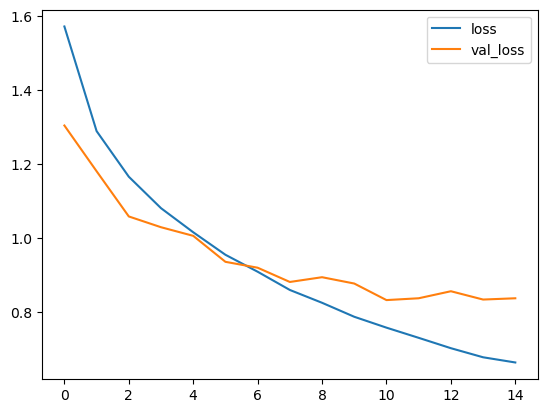

In [16]:
# Plot the loss

plt.plot(model.history.history['loss'], label = 'loss')
plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.legend();

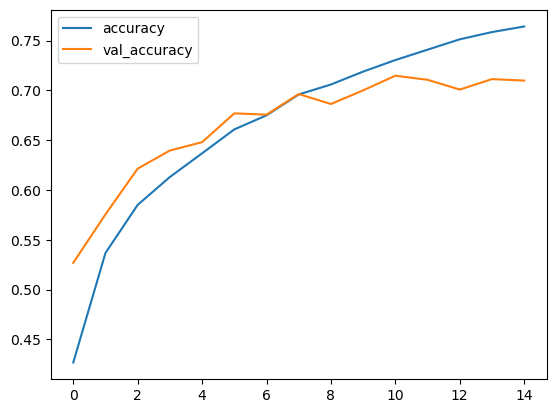

In [17]:
# Plot the accuracy

plt.plot(model.history.history['accuracy'], label = 'accuracy')
plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();

313/313 [==============================] - 1s 3ms/step


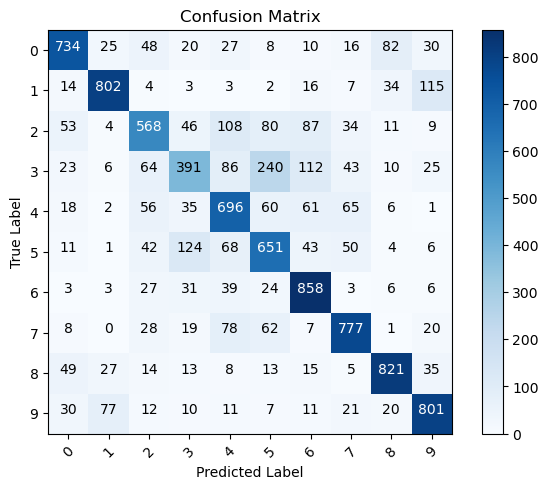

In [21]:
# Plot Confusion Matrix

pred = model.predict(x_test).argmax(axis = 1)
cm = confusion_matrix(y_test, pred)

plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(10)))
plt.xticks(tick_marks, list(range(10)), rotation = 45)
plt.yticks(tick_marks, list(range(10)))


thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
            horizontalalignment = "center", 
            color = "white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [22]:
# Mapping the labels

labels = """
Airplane
Automobile
Bird
Cat
Deer
Dog
Frog
Horse
Ship
Truck""".split()

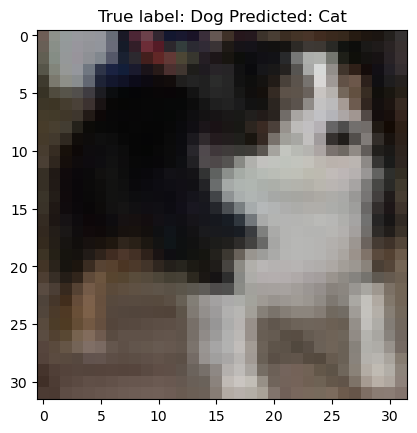

In [25]:
# Show some misclassified examples

misclassified_idx = np.where(pred != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i])
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[pred[i]]));

### Batch Normalization

On previous applications, we normalized the data before feeding it to the network. But since this is an operation on the data, only the first layers of the model will see this normalized data. After the data passes through the Dense layer, it is no longer normalized. 

The Batch Normalization is a layer that looks at each batch, and calculates the mean and the standard deviation on the fly. The equation can be represented as follows:

\begin{equation}
    z = (x - \mu)/\sigma
\end{equation}

The mean and standard deviation are calculated on the current batch, and the parameters are learned via gradient descent. 
Batch Normalization acts as a form of regularization, as methods such as Dropout (to prevent overfitting, for example).

In [31]:
# Build the model using the functional API

i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model_norm = Model(i, x)

In [32]:
# Compile

model_norm.compile(optimizer = 'adam',
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

In [33]:
# Fit the model

model_norm.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50)

Epoch 1/50
1563/1563 [==============================] - 22s 10ms/step - loss: 1.3024 - accuracy: 0.5529 - val_loss: 1.0386 - val_accuracy: 0.6431
Epoch 2/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8457 - accuracy: 0.7060 - val_loss: 0.8338 - val_accuracy: 0.7108
Epoch 3/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6902 - accuracy: 0.7632 - val_loss: 0.6926 - val_accuracy: 0.7663
Epoch 4/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5804 - accuracy: 0.8009 - val_loss: 0.6446 - val_accuracy: 0.7795
Epoch 5/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4940 - accuracy: 0.8307 - val_loss: 0.6269 - val_accuracy: 0.7959
Epoch 6/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.4175 - accuracy: 0.8566 - val_loss: 0.6728 - val_accuracy: 0.7913
Epoch 7/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.3550 - accuracy: 0.8756 - val_loss: 0.5974 - v

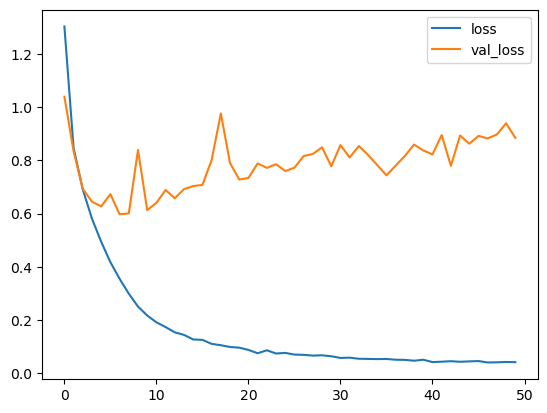

In [34]:
# Plot the loss

plt.plot(model_norm.history.history['loss'], label='loss')
plt.plot(model_norm.history.history['val_loss'], label='val_loss')
plt.legend();

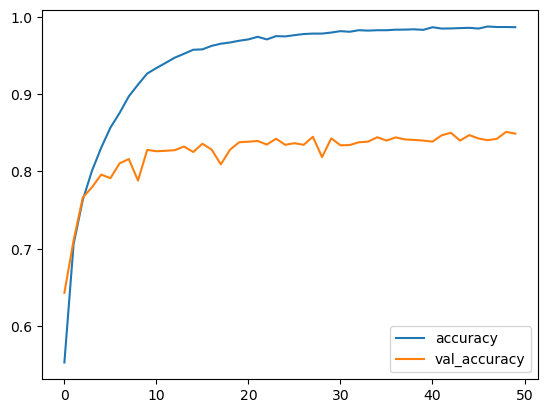

In [35]:
# Plot the accuracy

plt.plot(model_norm.history.history['accuracy'], label = 'accuracy')
plt.plot(model_norm.history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();

### Data Augmentation

Data augmentation is the process of artificially generating new data from existing data. It is a technique to increase the diversity of the training set by applying random (but realistic) transformations. With images, this can be done by applying filters, such as blur, or resizing and rescaling the data, and so on. 

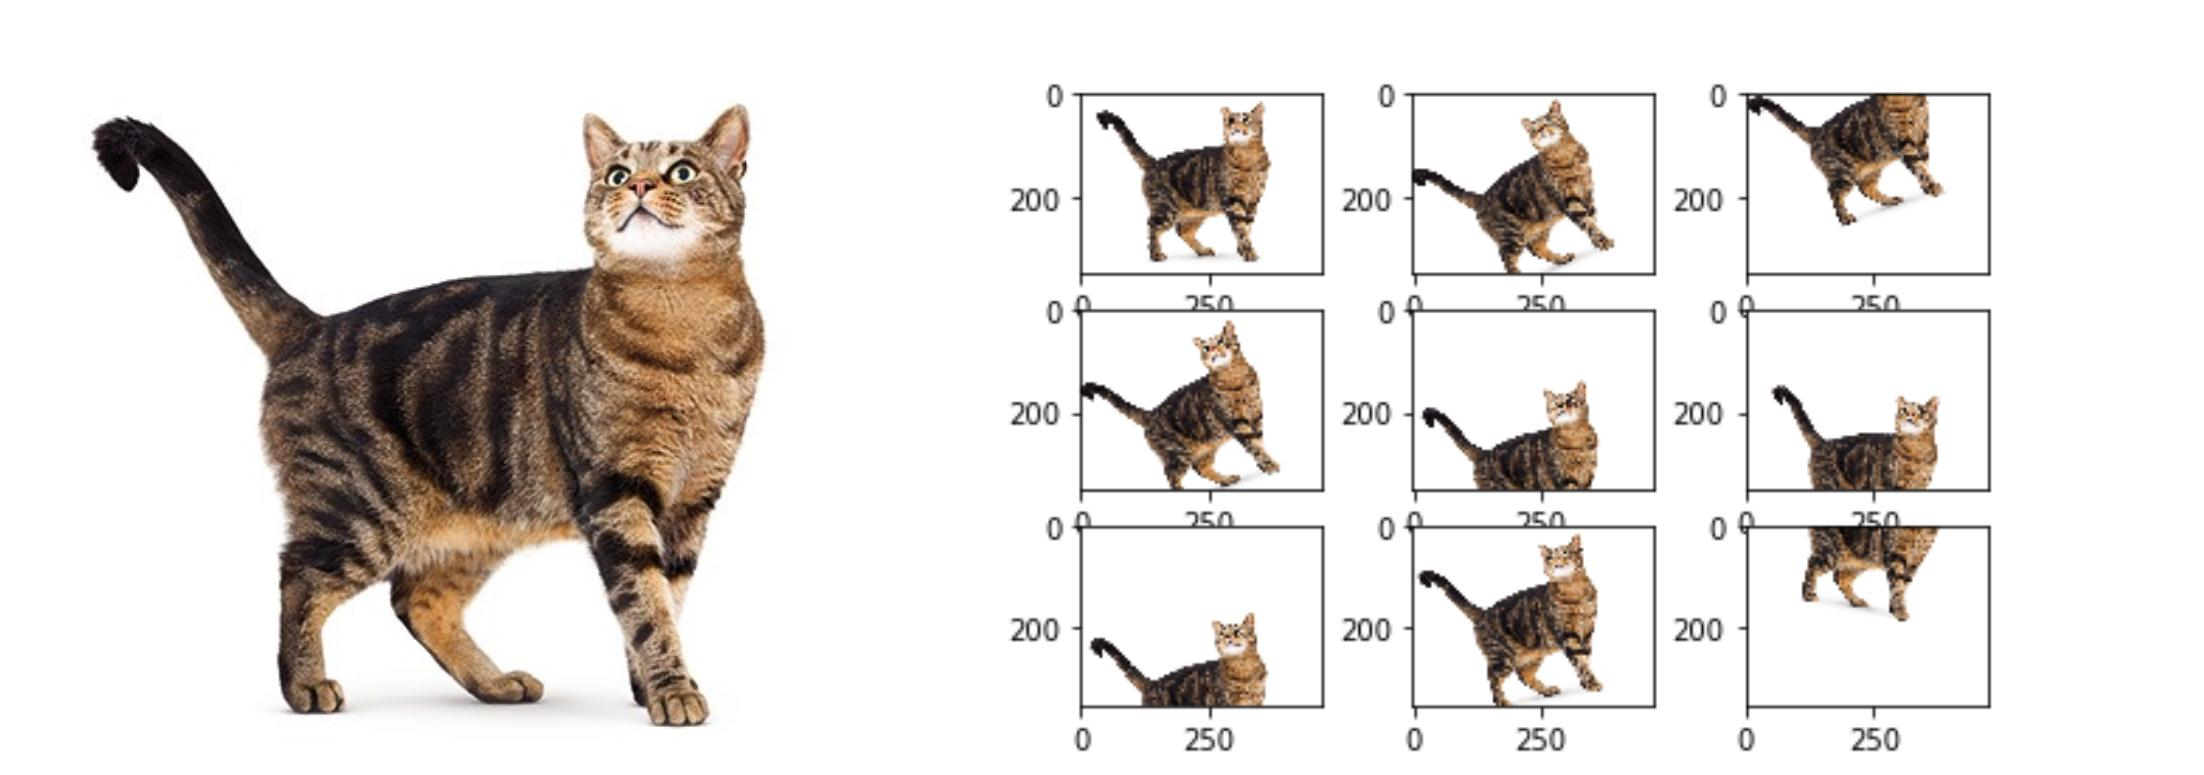

In [37]:
# Since the model using a Data Augmentation strategy uses the same structure as the model using Batch Normalization 
# We specify the model again. That is because if we call model.fit() on the same object, it will CONTINUE training where it left off

i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model_augm = Model(i, x)

In [38]:
# Compile the Model

model_augm.compile(optimizer = 'adam',
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

In [39]:
# Fit with data augmentation
# The strategy used for data augmentation here is to shift the width and height of the images by 10%, and apply a horizontal flip

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
train_generator = data_generator.flow(x_train, y_train, batch_size = batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
model_augm.fit(train_generator, validation_data = (x_test, y_test), steps_per_epoch = steps_per_epoch, epochs = 50)

Epoch 1/50
1562/1562 [==============================] - 24s 13ms/step - loss: 1.4514 - accuracy: 0.4946 - val_loss: 1.3565 - val_accuracy: 0.5466
Epoch 2/50
1562/1562 [==============================] - 21s 13ms/step - loss: 0.9986 - accuracy: 0.6511 - val_loss: 1.0069 - val_accuracy: 0.6519
Epoch 3/50
1562/1562 [==============================] - 17s 11ms/step - loss: 0.8506 - accuracy: 0.7083 - val_loss: 0.7504 - val_accuracy: 0.7394
Epoch 4/50
1562/1562 [==============================] - 17s 11ms/step - loss: 0.7623 - accuracy: 0.7409 - val_loss: 1.1428 - val_accuracy: 0.6249
Epoch 5/50
1562/1562 [==============================] - 17s 11ms/step - loss: 0.6936 - accuracy: 0.7634 - val_loss: 0.7140 - val_accuracy: 0.7521
Epoch 6/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.6412 - accuracy: 0.7798 - val_loss: 0.6922 - val_accuracy: 0.7636
Epoch 7/50
1562/1562 [==============================] - 18s 11ms/step - loss: 0.5920 - accuracy: 0.7979 - val_loss: 0.6550 -

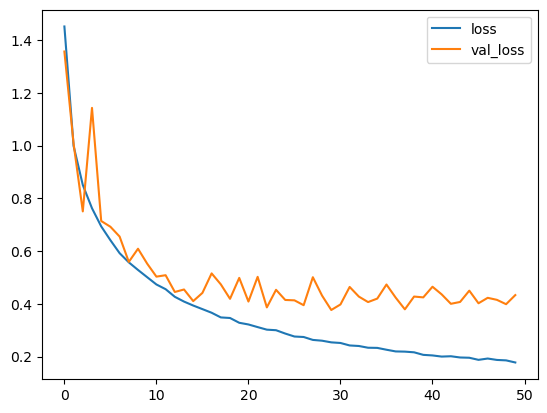

In [40]:
# Plot the loss

plt.plot(model_augm.history.history['loss'], label='loss')
plt.plot(model_augm.history.history['val_loss'], label='val_loss')
plt.legend();

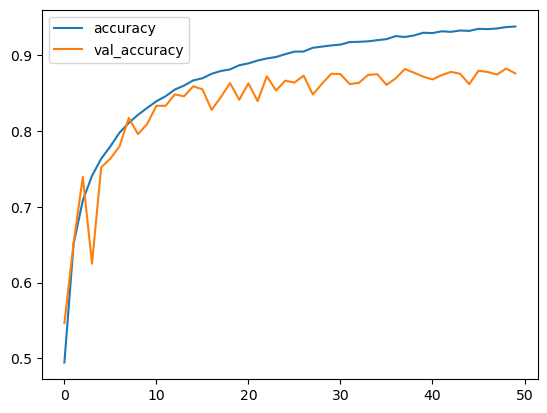

In [41]:
# Plot the accuracy

plt.plot(model_augm.history.history['accuracy'], label = 'accuracy')
plt.plot(model_augm.history.history['val_accuracy'], label = 'val_accuracy')
plt.legend();

### Evaluation

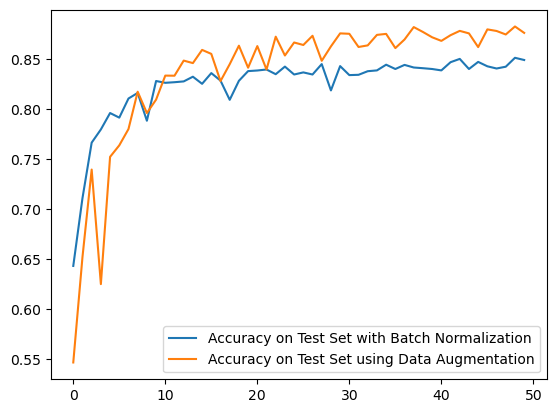

In [42]:
# Plot the accuracy of both models

plt.plot(model_norm.history.history['val_accuracy'], label = 'Accuracy on Test Set with Batch Normalization')
plt.plot(model_augm.history.history['val_accuracy'], label = 'Accuracy on Test Set using Data Augmentation')
plt.legend();

In [43]:
# Print the metrics of both models

print("Evaluate Model with Batch Normalization:", model_norm.evaluate(x_test, y_test))
print("Evaluate Model using Data Augmentation:", model_augm.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 0.8843 - accuracy: 0.8489
Evaluate Model with Batch Normalization: [0.8843196034431458, 0.8489000201225281]
313/313 [==============================] - 1s 4ms/step - loss: 0.4331 - accuracy: 0.8760
Evaluate Model using Data Augmentation: [0.43310338258743286, 0.8759999871253967]


From the previous executions, we can see that applying the method of Data Augmentation can increase the performance of the models.

Besides, it is also worth poiting that the loss in the test set with Batch Normalization reaches a plateau and does not decrease anymore.